In [32]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
# Om			\Omega_m
# Obh2			\Omega_{b}h^2
# h	
datafile = 'chains/LCDM_phy_HD_nested_dynesty_multi_1.txt'

In [4]:
class LoadDataSet(torch.utils.data.Dataset):
    '''
    Prepare the dataset for regression
    '''
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        ncols = 3
        self.layers = nn.Sequential(
          nn.Linear(ncols, 200),
          nn.ReLU(),
          nn.Linear(200, 200),
          nn.ReLU(),
          nn.Linear(200, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [6]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(42)
  
    # Load Boston dataset
    X = np.loadtxt(datafile, usecols=(2,3,4))
    y = np.loadtxt(datafile, usecols=1).reshape(-1, 1)
    randomize = np.random.permutation(len(X))
    X = X[randomize]
    y = y[randomize]
    print(np.shape(X), np.shape(y))
    X_test, y_test = X[:100, :], y[:100, :]
    X, y = X[100:, :], y[100:, :]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

(1036, 3) (1036, 1)


In [7]:
dataset_train = LoadDataSet(X_train, y_train)
dataset_val = LoadDataSet(X_val, y_val)
# dataset_test = LoadDataSet(X_test, y_test)
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [8]:
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(dataset_val, batch_size=10, shuffle=True, num_workers=1)

In [9]:
# Initialize the MLP
mlp = MLP()
mlp.float()
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [10]:
summary(mlp, batch_size=-1)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       201
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0

In [11]:
# Run the training loop
history_train = np.empty((1,))
history_val = np.empty((1,))
for epoch in range(0, 100): # 5 epochs at maximum  
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

          # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
                  (i + 1, loss.item()))
            current_loss = 0.0
    history_train = np.append(history_train, current_loss)

    
    valid_loss = 0.0
    mlp.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(validloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        output_val = mlp(inputs)
        valid_loss = loss_function(output_val, targets)
    
        valid_loss += loss.item()
    history_val = np.append(history_val, valid_loss.item())
    print('Training Loss: {:.3f} \t\t Validation Loss:'\
         '{:.3f}'.format(loss.item(), valid_loss.item()))
#     print('Training Loss: {:.3f} \t\t Validation Loss:'\
#           '{:.3f}'.format(current_loss / len(trainloader), valid_loss / len(validloader)))
#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
#         # Saving State Dict
#         torch.save(model.state_dict(), 'saved_model.pth')

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 19.430
Loss after mini-batch    11: 15.020
Loss after mini-batch    21: 11.495
Loss after mini-batch    31: 13.113
Loss after mini-batch    41: 9.104
Loss after mini-batch    51: 14.056
Loss after mini-batch    61: 12.764
Loss after mini-batch    71: 18.327
Training Loss: 9.136 		 Validation Loss:19.586
Starting epoch 2
Loss after mini-batch     1: 10.538
Loss after mini-batch    11: 6.027
Loss after mini-batch    21: 7.252
Loss after mini-batch    31: 16.961
Loss after mini-batch    41: 5.681
Loss after mini-batch    51: 14.572
Loss after mini-batch    61: 6.854
Loss after mini-batch    71: 11.067
Training Loss: 7.556 		 Validation Loss:18.803
Starting epoch 3
Loss after mini-batch     1: 4.196
Loss after mini-batch    11: 4.367
Loss after mini-batch    21: 9.973
Loss after mini-batch    31: 3.377
Loss after mini-batch    41: 12.085
Loss after mini-batch    51: 3.592
Loss after mini-batch    61: 5.360
Loss after mini-batch    71: 14.002
Tr

Training Loss: 0.124 		 Validation Loss:1.018
Starting epoch 25
Loss after mini-batch     1: 0.692
Loss after mini-batch    11: 0.808
Loss after mini-batch    21: 1.529
Loss after mini-batch    31: 2.162
Loss after mini-batch    41: 0.548
Loss after mini-batch    51: 0.755
Loss after mini-batch    61: 1.501
Loss after mini-batch    71: 3.761
Training Loss: 1.355 		 Validation Loss:3.163
Starting epoch 26
Loss after mini-batch     1: 0.755
Loss after mini-batch    11: 1.039
Loss after mini-batch    21: 1.863
Loss after mini-batch    31: 0.179
Loss after mini-batch    41: 0.956
Loss after mini-batch    51: 0.160
Loss after mini-batch    61: 2.009
Loss after mini-batch    71: 0.320
Training Loss: 0.560 		 Validation Loss:1.702
Starting epoch 27
Loss after mini-batch     1: 0.335
Loss after mini-batch    11: 6.090
Loss after mini-batch    21: 1.271
Loss after mini-batch    31: 0.985
Loss after mini-batch    41: 2.934
Loss after mini-batch    51: 1.292
Loss after mini-batch    61: 2.101
Los

Training Loss: 1.143 		 Validation Loss:2.097
Starting epoch 49
Loss after mini-batch     1: 0.394
Loss after mini-batch    11: 1.818
Loss after mini-batch    21: 0.186
Loss after mini-batch    31: 0.058
Loss after mini-batch    41: 0.529
Loss after mini-batch    51: 0.445
Loss after mini-batch    61: 0.287
Loss after mini-batch    71: 0.154
Training Loss: 0.196 		 Validation Loss:0.598
Starting epoch 50
Loss after mini-batch     1: 0.299
Loss after mini-batch    11: 0.510
Loss after mini-batch    21: 0.273
Loss after mini-batch    31: 1.490
Loss after mini-batch    41: 0.666
Loss after mini-batch    51: 0.323
Loss after mini-batch    61: 0.560
Loss after mini-batch    71: 0.266
Training Loss: 0.059 		 Validation Loss:0.202
Starting epoch 51
Loss after mini-batch     1: 0.847
Loss after mini-batch    11: 0.646
Loss after mini-batch    21: 0.463
Loss after mini-batch    31: 0.269
Loss after mini-batch    41: 0.110
Loss after mini-batch    51: 0.939
Loss after mini-batch    61: 1.445
Los

Training Loss: 3.624 		 Validation Loss:5.205
Starting epoch 73
Loss after mini-batch     1: 0.070
Loss after mini-batch    11: 0.158
Loss after mini-batch    21: 0.813
Loss after mini-batch    31: 0.066
Loss after mini-batch    41: 0.251
Loss after mini-batch    51: 0.200
Loss after mini-batch    61: 0.161
Loss after mini-batch    71: 0.279
Training Loss: 0.717 		 Validation Loss:1.731
Starting epoch 74
Loss after mini-batch     1: 0.186
Loss after mini-batch    11: 0.174
Loss after mini-batch    21: 0.135
Loss after mini-batch    31: 0.057
Loss after mini-batch    41: 3.688
Loss after mini-batch    51: 0.071
Loss after mini-batch    61: 0.738
Loss after mini-batch    71: 0.050
Training Loss: 0.651 		 Validation Loss:1.031
Starting epoch 75
Loss after mini-batch     1: 0.089
Loss after mini-batch    11: 0.132
Loss after mini-batch    21: 1.230
Loss after mini-batch    31: 1.096
Loss after mini-batch    41: 0.849
Loss after mini-batch    51: 0.147
Loss after mini-batch    61: 0.194
Los

Loss after mini-batch    71: 0.162
Training Loss: 3.967 		 Validation Loss:4.154
Starting epoch 97
Loss after mini-batch     1: 0.500
Loss after mini-batch    11: 0.166
Loss after mini-batch    21: 0.134
Loss after mini-batch    31: 0.156
Loss after mini-batch    41: 0.344
Loss after mini-batch    51: 0.065
Loss after mini-batch    61: 0.518
Loss after mini-batch    71: 0.395
Training Loss: 0.027 		 Validation Loss:0.720
Starting epoch 98
Loss after mini-batch     1: 0.211
Loss after mini-batch    11: 1.521
Loss after mini-batch    21: 0.288
Loss after mini-batch    31: 0.402
Loss after mini-batch    41: 0.605
Loss after mini-batch    51: 0.944
Loss after mini-batch    61: 0.119
Loss after mini-batch    71: 0.080
Training Loss: 0.480 		 Validation Loss:1.379
Starting epoch 99
Loss after mini-batch     1: 0.072
Loss after mini-batch    11: 0.360
Loss after mini-batch    21: 0.106
Loss after mini-batch    31: 0.068
Loss after mini-batch    41: 0.290
Loss after mini-batch    51: 0.049
Los

In [12]:
# test = np.random.randn(13)
# torch usa tensores de torch y no numpy.darrays
dtype = torch.float
test = torch.randn((1, 3), device=device, dtype=dtype)

In [13]:
y_pred = mlp.forward(X_test)

In [14]:
y_pred[0].item()

9.502007484436035

In [24]:
X_test[0, 0], X_test[0]
# xtest = [x[0] for x in X_test]
ypred = [y[0].item() for y in y_pred]
ytest = [y[0].item() for y in y_test]
diff=np.array(ytest)-np.array(ypred)
len(diff)

100

(0.0, 4.5)

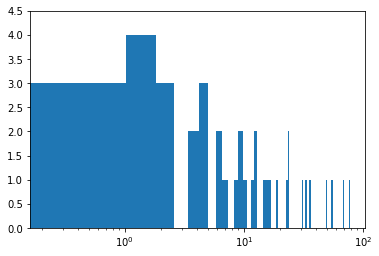

In [43]:
ys, _, _ = plt.hist(diff,bins=100)
plt.xscale('log')
plt.ylim(0,4.5)

In [44]:
ys

array([51.,  4.,  3.,  3.,  4.,  3.,  0.,  2.,  3.,  0.,  2.,  1.,  0.,
        1.,  2.,  1.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.])

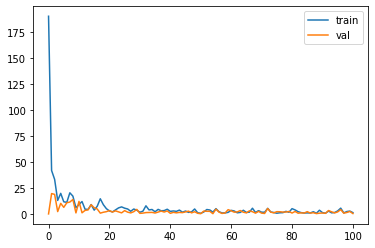

In [45]:
ep = np.arange(0, 101)
plt.plot(ep, history_train, label='train')
plt.plot(ep, history_val, label='val')
plt.legend()

In [18]:
np.shape(history_train), np.shape(history_val)

((101,), (101,))